In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load data from CSV files
departments = pd.read_csv('./RAW/departments.csv')
teams = pd.read_csv('./RAW/teams.csv')
users = pd.read_csv('./RAW/users.csv')
courses = pd.read_csv('./RAW/courses.csv')
learning_materials = pd.read_csv('./RAW/learning_materials.csv')
quizzes = pd.read_csv('./RAW/quizzes.csv')
questions = pd.read_csv('./RAW/questions.csv')
posts = pd.read_csv('./RAW/posts.csv')
feedbacks = pd.read_csv('./RAW/feedbacks.csv')
user_sessions = pd.read_csv('./RAW/user_sessions.csv')
results = pd.read_csv('./RAW/results.csv')
user_progress = pd.read_csv('./RAW/user_progress.csv')


In [23]:
# Display the first few rows of each DataFrame
print(departments.head())
print(teams.head())
print(users.head())
print(courses.head())
print(learning_materials.head())
print(quizzes.head())
print(questions.head())
print(posts.head())
print(feedbacks.head())
print(user_sessions.head())
print(results.head())
print(user_progress.head())

# Get summary statistics for numerical columns
print(users.describe())
print(courses.describe())
print(user_sessions.describe())
print(results.describe())


   id                name
0   1         Development
1   2   Quality Assurance
2   3              DevOps
3   4  Product Management
4   5     Human Resources
   id        name  departmentId
0   1    Frontend             1
1   2     Backend             1
2   3  Full Stack             1
3   4          QA             2
4   5  Automation             2
   id             name                      email    password  isAdmin  \
0   1   Joseph Schultz     danielle06@example.net  r4z^JDYE$Q     True   
1   2  Curtis Cardenas      gregory28@example.net  0S2LsXL2_*     True   
2   3     James Glover  brittneyscott@example.com  *Y7G*9Jt1U     True   
3   4     Diana Torres      vpeterson@example.org  X4GMgBvY#9    False   
4   5   Deanna Stanley    alejandro51@example.org  *DP$(4DfO&     True   

   departmentId  teamId  
0             9      13  
1            10      14  
2             6      14  
3             5       3  
4             5      21  
   id                                         name 

## Data Relationships and Insights

### 1. User Distribution by Teams and Departments

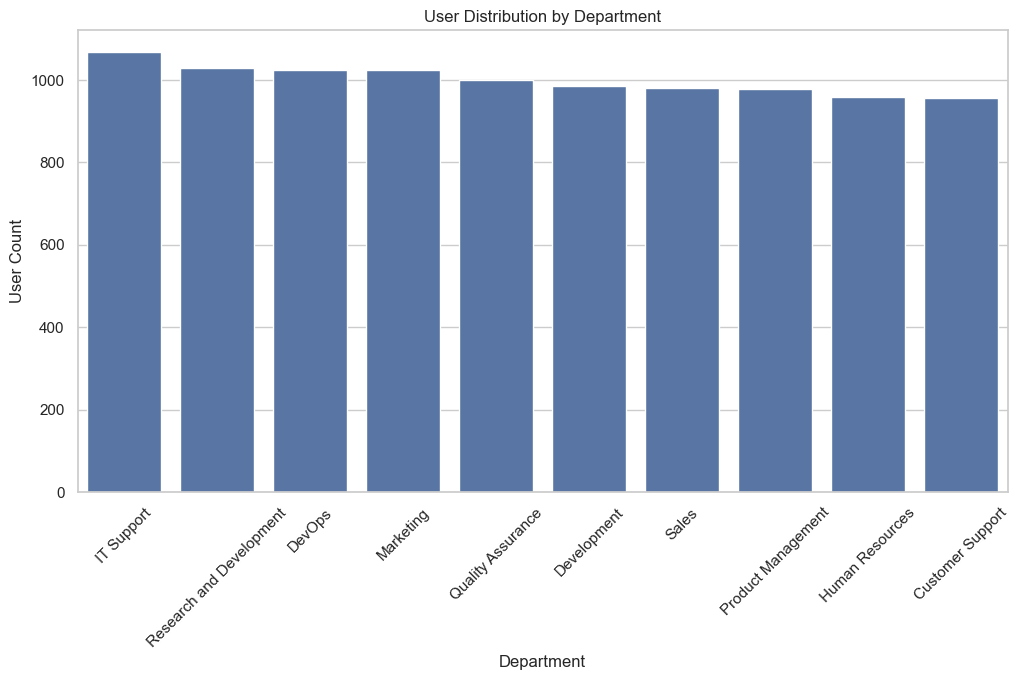

In [24]:


# Count of users by department
user_counts_by_department = users['departmentId'].value_counts().rename_axis('Department ID').reset_index(name='User Count')
user_counts_by_department = user_counts_by_department.merge(departments, left_on='Department ID', right_on='id')

plt.figure(figsize=(12, 6))
sns.barplot(x='name', y='User Count', data=user_counts_by_department)
plt.xticks(rotation=45)
plt.title('User Distribution by Department')
plt.ylabel('User Count')
plt.xlabel('Department')
plt.show()


### 2. Course Completion Rates

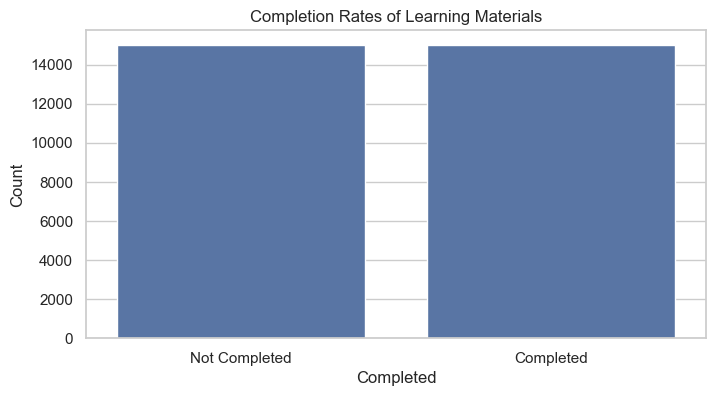

In [25]:
completion_rates = user_progress.groupby('completed').size().reset_index(name='Counts')

plt.figure(figsize=(8, 4))
sns.barplot(x='completed', y='Counts', data=completion_rates)
plt.title('Completion Rates of Learning Materials')
plt.xlabel('Completed')
plt.ylabel('Count')
plt.xticks(ticks=[0, 1], labels=['Not Completed', 'Completed'])
plt.show()


### 3. Learning Materials Distribution


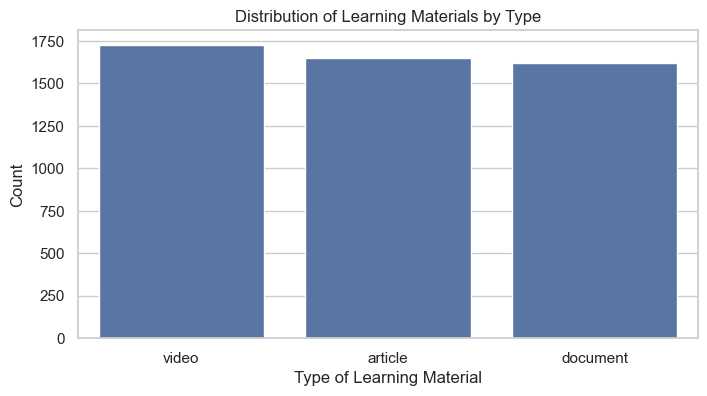

In [26]:
plt.figure(figsize=(8, 4))
sns.countplot(data=learning_materials, x='type')
plt.title('Distribution of Learning Materials by Type')
plt.xlabel('Type of Learning Material')
plt.ylabel('Count')
plt.show()


## Performance Analysis


### 1. Quiz Results Analysis

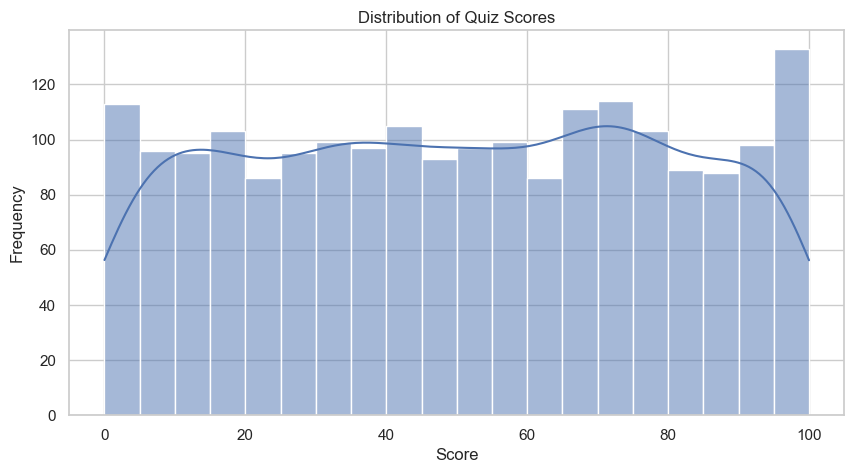

In [27]:
plt.figure(figsize=(10, 5))
sns.histplot(results['score'], bins=20, kde=True)
plt.title('Distribution of Quiz Scores')
plt.xlabel('Score')
plt.ylabel('Frequency')
plt.show()


### 2. Feedback Ratings


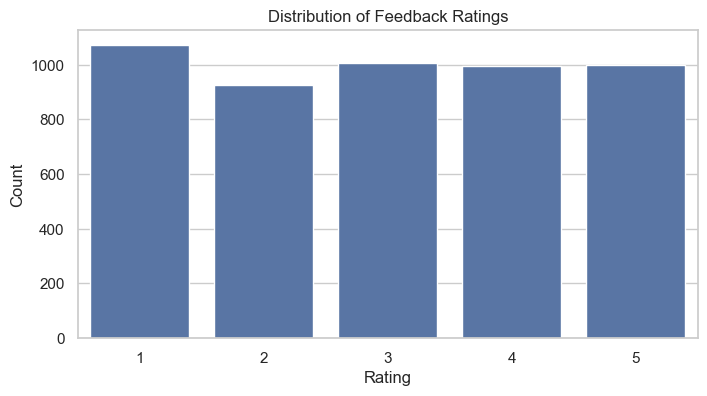

In [28]:
plt.figure(figsize=(8, 4))
sns.countplot(data=feedbacks, x='rating')
plt.title('Distribution of Feedback Ratings')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.show()


### 3. User Activity Analysis

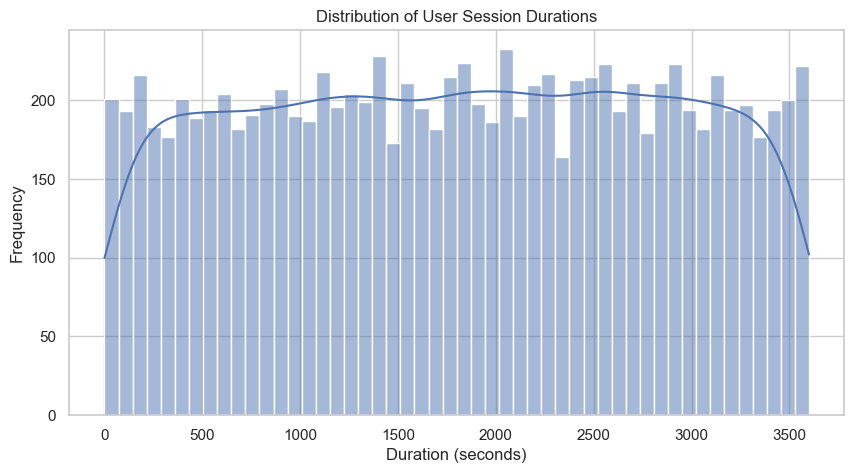

In [29]:
plt.figure(figsize=(10, 5))
sns.histplot(user_sessions['duration'], bins=50, kde=True)
plt.title('Distribution of User Session Durations')
plt.xlabel('Duration (seconds)')
plt.ylabel('Frequency')
plt.show()


## Feature Engineering

In [30]:
# Generate user engagement DataFrame
user_engagement = users[['id', 'departmentId', 'teamId']].copy()

# Learning materials completed
completed_materials = user_progress[user_progress['completed']].groupby('userId').size().reset_index(name='completed_materials')
completed_materials.rename(columns={'userId': 'id'}, inplace=True)  # Rename to match user_engagement
user_engagement = user_engagement.merge(completed_materials, on='id', how='left').fillna(0)

# Quizzes taken and average score
quizzes_taken = results.groupby('userId').agg({'quizId': 'count', 'score': 'mean'}).reset_index()
quizzes_taken.rename(columns={'userId': 'id'}, inplace=True)  # Rename to match user_engagement
quizzes_taken.columns = ['id', 'quizzes_taken', 'average_score']
user_engagement = user_engagement.merge(quizzes_taken, on='id', how='left').fillna(0)

# Feedback provided
feedback_counts = feedbacks.groupby('userId').size().reset_index(name='feedback_count')
feedback_counts.rename(columns={'userId': 'id'}, inplace=True)  # Rename to match user_engagement
user_engagement = user_engagement.merge(feedback_counts, on='id', how='left').fillna(0)

# Average session duration
average_session_duration = user_sessions.groupby('userId')['duration'].mean().reset_index(name='average_duration')
average_session_duration.rename(columns={'userId': 'id'}, inplace=True)  # Rename to match user_engagement
user_engagement = user_engagement.merge(average_session_duration, on='id', how='left').fillna(0)


# Normalize average_duration (e.g., min-max scaling)
user_engagement['normalized_duration'] = (user_engagement['average_duration'] - user_engagement['average_duration'].min()) / \
                                         (user_engagement['average_duration'].max() - user_engagement['average_duration'].min())

# Z-score normalization
user_engagement['z_score_duration'] = (user_engagement['average_duration'] - user_engagement['average_duration'].mean()) / \
                                       user_engagement['average_duration'].std()

# Calculate engagement level based on z-scored data
user_engagement['engagement_level'] = pd.cut(
    user_engagement[['completed_materials', 'quizzes_taken', 'feedback_count', 'z_score_duration']].sum(axis=1),
    bins=[-1.5, 0, 3, float('inf')],
    labels=['Low', 'Medium', 'High']
)
print(user_engagement)

         id  departmentId  teamId  completed_materials  quizzes_taken  \
0         1             9      13                  0.0            0.0   
1         2            10      14                  0.0            0.0   
2         3             6      14                  3.0            0.0   
3         4             5       3                  3.0            0.0   
4         5             5      21                  1.0            1.0   
...     ...           ...     ...                  ...            ...   
9995   9996             2      21                  0.0            0.0   
9996   9997             1       5                  4.0            0.0   
9997   9998             6      17                  3.0            0.0   
9998   9999             8      22                  0.0            0.0   
9999  10000             5      22                  4.0            0.0   

      average_score  feedback_count  average_duration  normalized_duration  \
0               0.0             0.0          

## Revised Feature Engineering

In [31]:

# Generate user engagement DataFrame
user_engagement = users[['id', 'departmentId', 'teamId']].copy()

# Learning materials completed
completed_materials = user_progress[user_progress['completed']].groupby('userId').size().reset_index(name='completed_materials')
completed_materials.rename(columns={'userId': 'id'}, inplace=True)  # Rename to match user_engagement
user_engagement = user_engagement.merge(completed_materials, on='id', how='left').fillna(0)

# Quizzes taken and average score
quizzes_taken = results.groupby('userId').agg({'quizId': 'count', 'score': 'mean'}).reset_index()
quizzes_taken.rename(columns={'userId': 'id'}, inplace=True)  # Rename to match user_engagement
quizzes_taken.columns = ['id', 'quizzes_taken', 'average_score']
user_engagement = user_engagement.merge(quizzes_taken, on='id', how='left').fillna(0)

# Feedback provided
feedback_counts = feedbacks.groupby('userId').size().reset_index(name='feedback_count')
feedback_counts.rename(columns={'userId': 'id'}, inplace=True)  # Rename to match user_engagement
user_engagement = user_engagement.merge(feedback_counts, on='id', how='left').fillna(0)

# Average session duration
average_session_duration = user_sessions.groupby('userId')['duration'].mean().reset_index(name='average_duration')
average_session_duration.rename(columns={'userId': 'id'}, inplace=True)  # Rename to match user_engagement
user_engagement = user_engagement.merge(average_session_duration, on='id', how='left').fillna(0)

# Z-score normalization for relevant metrics
metrics_to_normalize = ['completed_materials', 'quizzes_taken', 'feedback_count', 'average_duration']

for metric in metrics_to_normalize:
    user_engagement[f'z_score_{metric}'] = (user_engagement[metric] - user_engagement[metric].mean()) / user_engagement[metric].std()

# Introduce noise to completed_materials and other metrics
for metric in metrics_to_normalize:
    noise = np.random.normal(0, 0.5 * user_engagement[metric].std(), user_engagement[metric].shape)
    user_engagement[metric] += noise

# Calculate engagement level based on z-scored data
user_engagement['engagement_score'] = user_engagement[[f'z_score_{metric}' for metric in metrics_to_normalize]].sum(axis=1)

# Define engagement levels based on the engagement score
user_engagement['engagement_level'] = pd.cut(
    user_engagement['engagement_score'],
    bins=[-float('inf'), -1, 0, float('inf')],
    labels=['Low', 'Medium', 'High']
)

print(user_engagement['engagement_level'].value_counts())


engagement_level
High      4572
Low       3358
Medium    2070
Name: count, dtype: int64


In [32]:
user_engagement

,id,departmentId,teamId,completed_materials,quizzes_taken,average_score,feedback_count,average_duration,z_score_completed_materials,z_score_quizzes_taken,z_score_feedback_count,z_score_average_duration,engagement_score,engagement_level
0,1,9,13,-0.259576,-0.306359,0.0,-0.174315,117.693105,-1.221516,-0.448991,-0.710777,-1.001162,-3.382446,Low
1,2,10,14,0.312445,0.073646,0.0,0.077796,1447.143443,-1.221516,-0.448991,-0.710777,0.193181,-2.188103,Low
2,3,6,14,3.535941,-0.017638,0.0,1.261239,390.956077,1.220051,-0.448991,0.710777,-1.001162,0.480676,High
3,4,5,3,2.187987,-0.052596,0.0,1.107114,520.216747,1.220051,-0.448991,0.710777,-1.001162,0.480676,High
4,5,5,21,1.404181,0.676173,62.0,0.473705,2255.256504,-0.407660,1.795963,-0.710777,0.674543,1.352068,High
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,9996,2,21,-0.291505,0.094553,0.0,1.717422,211.662867,-1.221516,-0.448991,0.710777,-1.001162,-1.960892,Low
9996,9997,1,5,4.177870,-0.090109,0.0,-0.853470,-220.655238,2.033907,-0.448991,-0.710777,-1.001162,-0.127023,Medium
9997,9998,6,17,2.488021,0.401642,0.0,1.101451,2349.228175,1.220051,-0.448991,0.710777,0.388113,1.869950,High
9998,9999,8,22,0.614091,0.152691,0.0,0.310287,-246.743868,-1.221516,-0.448991,-0.710777,-1.001162,-3.382446,Low


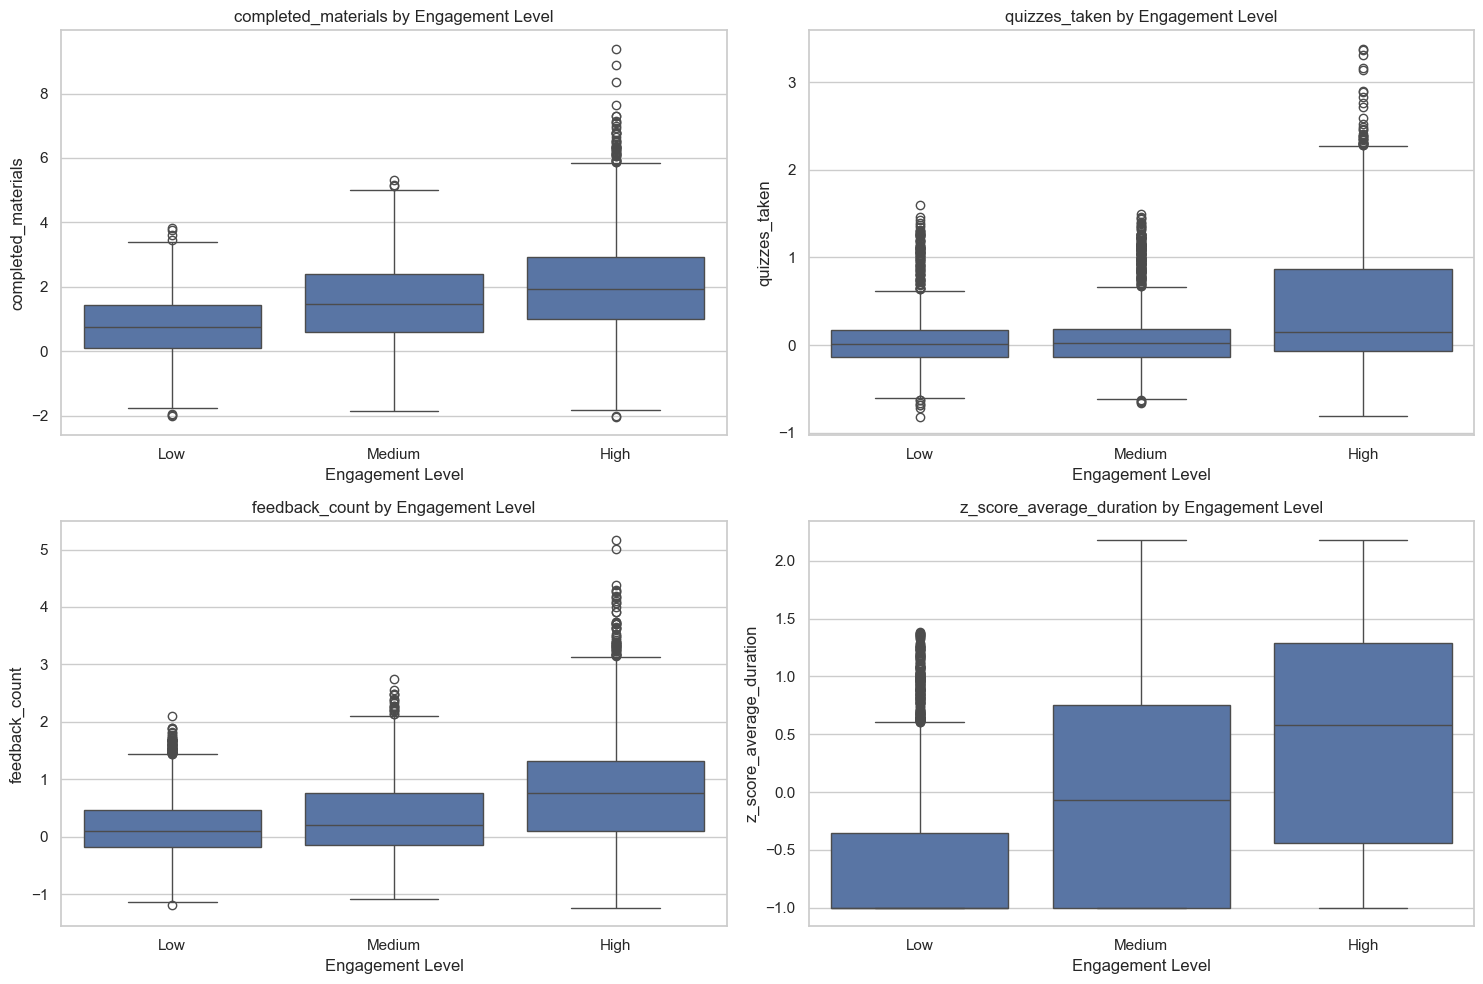

In [33]:
# Set the aesthetics for the plots
sns.set(style="whitegrid")

# Visualize the relationship using boxplots
metrics_to_visualize = ['completed_materials', 'quizzes_taken', 'feedback_count', 'z_score_average_duration']

plt.figure(figsize=(15, 10))

for i, metric in enumerate(metrics_to_visualize):
    plt.subplot(2, 2, i + 1)
    sns.boxplot(x='engagement_level', y=metric, data=user_engagement)
    plt.title(f'{metric} by Engagement Level')
    plt.ylabel(metric)
    plt.xlabel('Engagement Level')

plt.tight_layout()
plt.show()


In [34]:
# Get the distribution of engagement levels
engagement_distribution = user_engagement['engagement_level'].value_counts()

# Display the distribution
print(engagement_distribution)


engagement_level
High      4572
Low       3358
Medium    2070
Name: count, dtype: int64


## Model

### 1. Split train test data

In [35]:
from sklearn.model_selection import train_test_split

# Encode categorical variables
X = pd.get_dummies(user_engagement.drop(columns=['engagement_level', 'departmentId', 'teamId','z_score_average_duration','z_score_quizzes_taken', 'z_score_completed_materials', 'z_score_feedback_count' ,'engagement_score', 'id']), drop_first=True)
y = user_engagement['engagement_level']
print(y.isna().sum())
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


0


### 2. Model Training

In [36]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score

# Initialize and train the model
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate the model
print(classification_report(y_test, y_pred))
print(f'Accuracy: {accuracy_score(y_test, y_pred)}')


              precision    recall  f1-score   support

        High       0.85      0.88      0.86       901
         Low       0.82      0.84      0.83       696
      Medium       0.53      0.47      0.50       403

    accuracy                           0.78      2000
   macro avg       0.73      0.73      0.73      2000
weighted avg       0.78      0.78      0.78      2000

Accuracy: 0.783


### 3. Feature importance

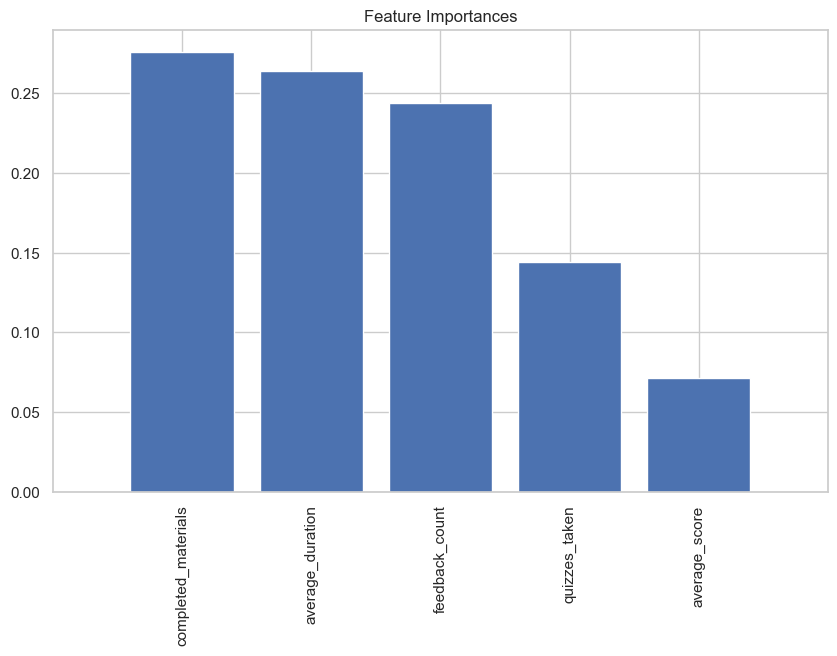

In [37]:
import matplotlib.pyplot as plt
import numpy as np

# Get feature importances
importances = model.feature_importances_
indices = np.argsort(importances)[::-1]

# Plot feature importances
plt.figure(figsize=(10, 6))
plt.title("Feature Importances")
plt.bar(range(X.shape[1]), importances[indices], align="center")
plt.xticks(range(X.shape[1]), X.columns[indices], rotation=90)
plt.xlim([-1, X.shape[1]])
plt.show()


### Multiple models

In [38]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report, accuracy_score

In [39]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
def evaluate_model(model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred)
    
    return accuracy, report


In [40]:
models = {
    "Logistic Regression": LogisticRegression(),
    "Decision Tree": DecisionTreeClassifier(),
    "Support Vector Machine": SVC(probability=True),
    "K-Nearest Neighbors": KNeighborsClassifier(),
    "Gradient Boosting": GradientBoostingClassifier(),
}

results = {}

for model_name, model in models.items():
    accuracy, report = evaluate_model(model, X_train, X_test, y_train, y_test)
    results[model_name] = {"Accuracy": accuracy, "Report": report}


c:\Users\Admi\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\Admi\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Admi\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1

Model: Logistic Regression
Accuracy: 0.7275
Classification Report:
              precision    recall  f1-score   support

        High       0.76      0.89      0.82       901
         Low       0.72      0.88      0.79       696
      Medium       0.43      0.11      0.17       403

    accuracy                           0.73      2000
   macro avg       0.64      0.62      0.60      2000
weighted avg       0.68      0.73      0.68      2000

------------------------------------------------------------
Model: Decision Tree
Accuracy: 0.7230
Classification Report:
              precision    recall  f1-score   support

        High       0.82      0.82      0.82       901
         Low       0.78      0.76      0.77       696
      Medium       0.42      0.44      0.43       403

    accuracy                           0.72      2000
   macro avg       0.68      0.67      0.67      2000
weighted avg       0.73      0.72      0.72      2000

-------------------------------------------------

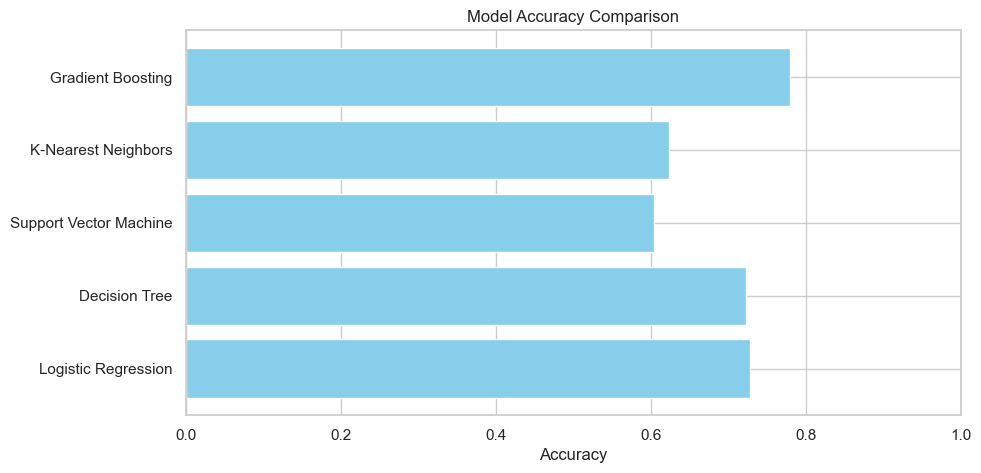

In [41]:
for model_name, metrics in results.items():
    print(f"Model: {model_name}")
    print(f"Accuracy: {metrics['Accuracy']:.4f}")
    print("Classification Report:")
    print(metrics['Report'])
    print("-" * 60)

import matplotlib.pyplot as plt

accuracy_scores = [metrics['Accuracy'] for metrics in results.values()]
model_names = list(results.keys())

plt.figure(figsize=(10, 5))
plt.barh(model_names, accuracy_scores, color='skyblue')
plt.xlabel('Accuracy')
plt.title('Model Accuracy Comparison')
plt.xlim(0, 1)
plt.show()
